In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker
!pip install scikit-learn


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1
**ansiedad** : 2



In [ ]:
num_docs = 20000

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/train.csv'
#data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train = data.iloc[:num_docs, :]
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     13422 non-null  object 
 1   TWEET_ID    13408 non-null  float64
 2   TWEET_TEXT  20000 non-null  object 
 3   trastorno   20000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 625.1+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,RT @FraRocanroleras: Te estás destruyendo y lo...,1
1,6,2.147484e+09,No sé cómo estar sin ti pero tampoco sé cómo e...,0
2,NaN,NaN,Me pregunto por qué últimamente no me siento ...,2
3,NaN,NaN,Mi ansiedad en torno a toda esta enfermedad s...,2
4,NaN,NaN,Esto ha estado en mi mente bastante durante lo...,2
5,NaN,NaN,¿Necesitas algunas ideas? Este canal es maravi...,2
6,31,2.147484e+09,"Intenté decir algo pero no pude,sólo quedé con...",0
7,27,2.147484e+09,tumblrbot ha preguntado: ROBOTS OR DINOSAURS? ...,1
8,49,2.147484e+09,El smirnoff es la bebida mas traicionera que e...,1
9,36,2.147484e+09,¿Por qué mis primas son delgadas y tan hermosa...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpiar texto*

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        words = text.split() #divide el texto en palabras individuales, creando una lista de palabras.

      # Combinar las stopwords en  español
        all_stopwords = stopwords_en
      # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
#data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,destruyendo único haces reírte,1
1,6,2.147484e+09,cómo tampoco cómo contigo,0
2,NaN,NaN,pregunto últimamente siento tranquilo punto au...,2
3,NaN,NaN,ansiedad torno toda enfermedad disparado,2
4,NaN,NaN,mente bastante últimos meses compañero cuarto ...,2
5,NaN,NaN,ideas canal maravilloso aquí historias siguen ...,2
6,31,2.147484e+09,intenté decir pudesólo quedé nudo garganta lág...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera existe chabon ...,1
9,36,2.147484e+09,primas delgadas tan hermosas vidas,0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 1099


In [ ]:
# Eliminar filas con valores nulos o vacíos en la columna 'TWEET_TEXT'
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación
empty_count_after = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos después de la eliminación
print("Número de elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación:", empty_count_after)

# También puedes reindexar el DataFrame después de eliminar las filas
data_train.reset_index(drop=True, inplace=True)


Número de elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación: 1099


In [ ]:
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corregir_palabras_largas)
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corrector_ortografico)

data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     13422 non-null  object 
 1   TWEET_ID    13408 non-null  float64
 2   TWEET_TEXT  20000 non-null  object 
 3   trastorno   20000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 625.1+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,destruyendo único haces reírte,1
1,6,2.147484e+09,cómo tampoco cómo contigo,0
2,NaN,NaN,pregunto últimamente siento tranquilo punto au...,2
3,NaN,NaN,ansiedad torno toda enfermedad disparado,2
4,NaN,NaN,mente bastante últimos meses compañero cuarto ...,2
5,NaN,NaN,ideas canal maravilloso aquí historias siguen ...,2
6,31,2.147484e+09,intenté decir pudesólo quedé nudo garganta lág...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera existe chabon ...,1
9,36,2.147484e+09,primas delgadas tan hermosas vidas,0


# Representación de los datos mediante una matriz TF-IDF

se guardan los valores de la matriz BoW y los array X y para futuros entrenamientos

Se procederá a construir un conjunto de entrenamiento a partir de la representación de bolsa de palabras o inglés (Bag of Words.)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
umbral = 5
def Tokenizer(text):
    return text.split()
# Crear un transformador TfidfVectorizer con el tokenizer extractTerms y rango de n-gramas (1, 1)
tfidf_vect  = TfidfVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)
# Aplicar el TfidfVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz TF-IDF
tfidf_train  = tfidf_vect.fit_transform(data_train['TWEET_TEXT'].values)
print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = tfidf_train # Matriz TF-IDF
y = data_train['trastorno'].values # Etiquetas de trastorno de la columna 'trastorno'

El tamaño del vocabulario es:  4389


# Entrenamiento y validación del modelo

In [ ]:
from sklearn.model_selection import train_test_split

#
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25)

# Aprendizaje del modelo: Maquina de Soporte Vectorial

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Suponiendo que ya tienes tus datos de entrenamiento y validación: X_train, X_val, y_train, y_val

# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='linear', degree=4, C=100,max_iter=500000,  probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))





Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 82.65%
Precisión (entrenamiento): 82.86%
Recall (entrenamiento): 82.65%
F1-score (entrenamiento): 82.66%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 56.96%
Precisión en el conjunto de validación: 57.90%
Recall en el conjunto de validación: 56.96%
F1-score en el conjunto de validación: 57.39%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)


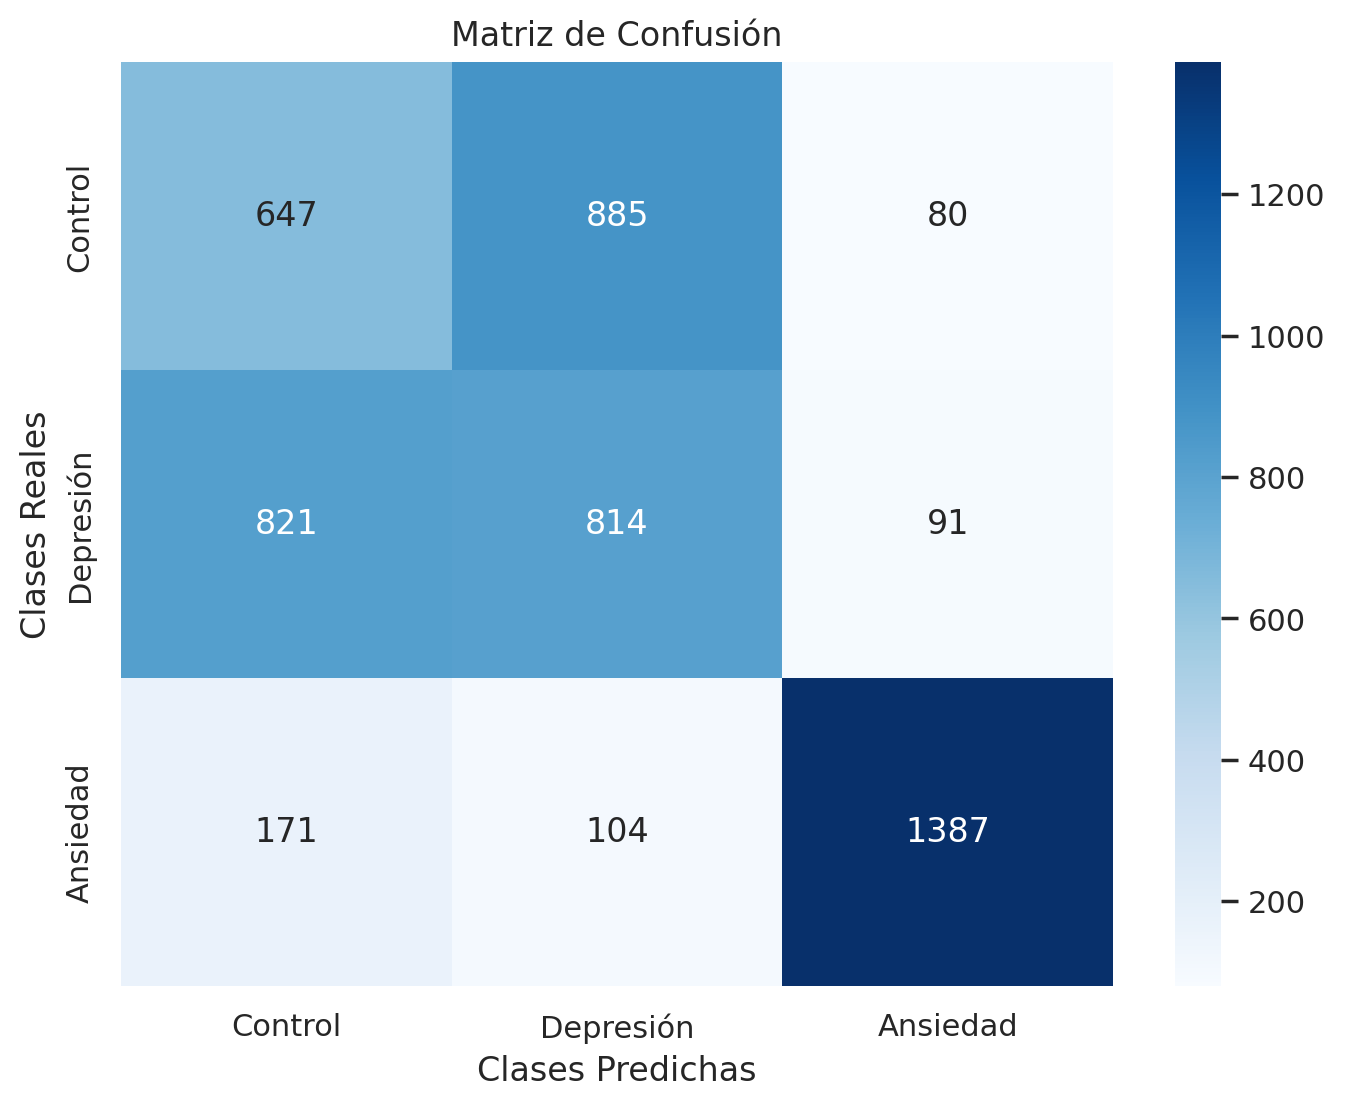

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Crear un modelo de SVM
svm_model_p = SVC(kernel='linear', degree=4, C=100, max_iter=500000, probability=False)

# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Entrenar el modelo en los datos de entrenamiento del fold
    svm_model_p.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = svm_model_p.predict(X_train_fold)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_fold, y_train_pred))
    train_precision_scores.append(precision_score(y_train_fold, y_train_pred, average='weighted'))
    train_recall_scores.append(recall_score(y_train_fold, y_train_pred, average='weighted'))
    train_f1_scores.append(f1_score(y_train_fold, y_train_pred, average='weighted'))

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = svm_model_p.predict(X_val_fold)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
    val_precision_scores.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
    val_recall_scores.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
    val_f1_scores.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

# Calcular las métricas promediadas en entrenamiento y validación
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en entrenamiento y validación
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

print("\nValidación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))



Entrenamiento - Accuracy: 83.70%
Entrenamiento - Precision: 83.94%
Entrenamiento - Recall: 83.70%
Entrenamiento - F1 Score: 83.71%

Validación - Accuracy: 57.15%
Validación - Precision: 58.12%
Validación - Recall: 57.15%
Validación - F1 Score: 57.56%


In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados'
model_filename = 'TWEETS_depresivos-ansiedad (SVM_p (Bow)).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(svm_model_p, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Modelos ya entrenados/TWEETS_depresivos-ansiedad (SVM_p (Bow)).pkl']

# matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
# y las columnas a las predicciones.
#
cm = confusion_matrix(y_val, y_pred)

# Obtiene la proporción real de comentarios positivos,
# y la proporción etiquetados.
#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[ 650  871   91]
 [ 823  812   91]
 [ 190  108 1364]] 

Proporción de comentarios positivos: 1.01
Proporción de comentarios positivos etiquetados: 0.34


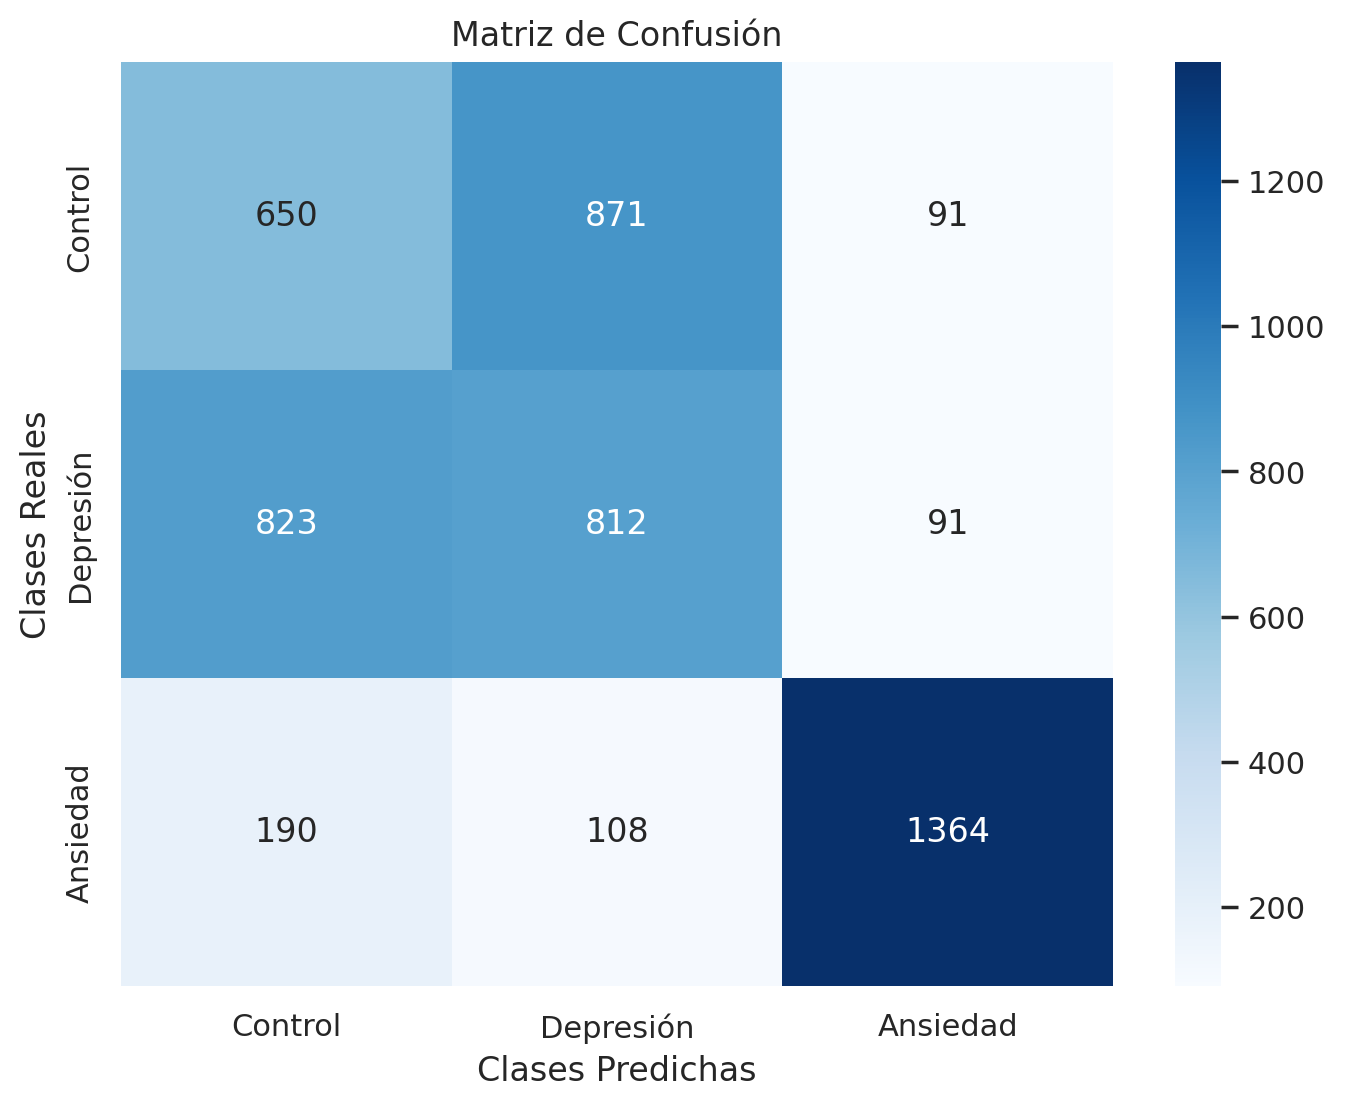

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()